# Summary

Tried several models, including logistic regression, a random forest model, and XGBoost. I optimized for accuracy, since it is the most interpretable, since the classes are balanced enough to do so, and since I don't need to prioritize recall or precision for any reason. I printed out other metrics to get a holistic sense of how each model was performing.

The best model was XGBoost, with an accuracy of 84%. The final accuracy on the test data was 78%.

After playing around with the features used in XGBoost, I realized that the only features contributing to the accuracy were Age, Sex, Addtl_HH_size, and LastPurchaseAmt.

# Import Libraries and Data

In [166]:
import pandas as pd

# Prepping for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score

# Creating models
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [167]:
df_train = pd.read_csv('train_df_cleaned.csv')
df_test = pd.read_csv('test_df_cleaned.csv')

In [168]:
df_train.drop(columns=['Unnamed: 0'], inplace = True)
df_test.drop(columns=['Unnamed: 0'], inplace = True)

In [169]:
df_train.head()

,Rewards_Signup,Age,Sex,Addtl_HH_size,LastPurchaseAmt,CustomerTier,New,Reactivated
0,1,29.0,0,0,10.5000,2,1,0
1,1,19.0,0,0,7.8792,3,0,0
2,0,25.0,1,0,7.0500,3,1,0
3,1,44.0,0,1,57.9792,1,0,1
4,1,32.0,1,0,7.9250,3,1,0


In [191]:
print('The majority class makes up ', round(df_train.Rewards_Signup.value_counts()[0] / (df_train.Rewards_Signup.value_counts()[0] + df_train.Rewards_Signup.value_counts()[1]) * 100, 2), '% of the examples')     
      

The majority class makes up  62.01 % of the examples


Since the majority class doesn't make up more than 80% of the examples in the target variable, I'll be using accuracy as my metric to compare models.

# Make confusion matrix

In [170]:
def make_confusion_matrix(model, threshold=.5):
    """
    Creates a heat map confusion matrix, and prints out precision, recall, F1,
    accuracy, training, and test scores.
    """
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    fig, ax = plt.subplots(figsize=(8,6))
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    functional_confusion = confusion_matrix(y_test, y_predict)

    #Print the heatmap
    group_names = ['True Neg','False Po','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
            functional_confusion.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
            functional_confusion.flatten()/np.sum(functional_confusion)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    xlabels = ['Did Not Sign Up', 'Signed Up']
    ylabels = ['Did Not Sign Up', 'Signed Up']
    sns.heatmap(functional_confusion, annot=labels, fmt='', cmap='Blues', 
                xticklabels=xlabels, yticklabels=ylabels)
    ax.set_ylim([2,0])
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
    #Print various scores/metrics
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
    print("F1 Score: ", f1_score(y_test, y_predict))
    print("ROC AUC score : ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    
    print("Accuracy score: ", accuracy_score(y_test, y_predict))
    
    print('Training accuracy:', model.score(X_train, y_train))
    print('Test accuracy:', model.score(X_test, y_test))

# Logistic Regression

In [171]:
# Define target and features
X = df_train.drop(columns='Rewards_Signup')
y = df_train['Rewards_Signup']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [172]:
# Scale since there are multiple features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # Scale test features

In [173]:
# Create the model
logistic_model = LogisticRegression(penalty='l1', solver='liblinear', C=.1) # Create model
logistic_model.fit(X_train, y_train) # Fit model on training data

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

Precision: 0.7097,   Recall: 0.6875
F1 Score:  0.6984126984126984
ROC AUC score :  0.8397253787878788
Accuracy score:  0.8061224489795918
Training accuracy: 0.8174807197943444
Test accuracy: 0.8061224489795918


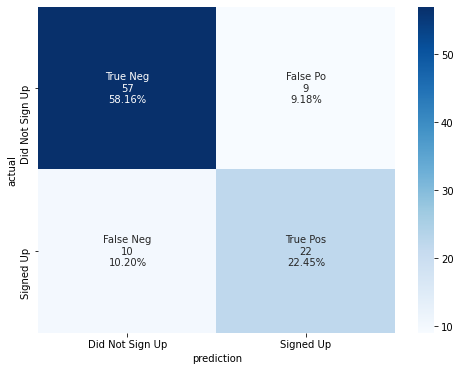

In [174]:
# Print confusion matrix with metrics
make_confusion_matrix(logistic_model)

# Random Forest Model

In [175]:
# Define target and features
X = df_train.drop(columns='Rewards_Signup')
y = df_train['Rewards_Signup']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [176]:
# Create the model
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

Precision: 0.6667,   Recall: 0.7500
F1 Score:  0.7058823529411765
ROC AUC score :  0.8612689393939394
Accuracy score:  0.7959183673469388
Training accuracy: 0.9845758354755784
Test accuracy: 0.7959183673469388


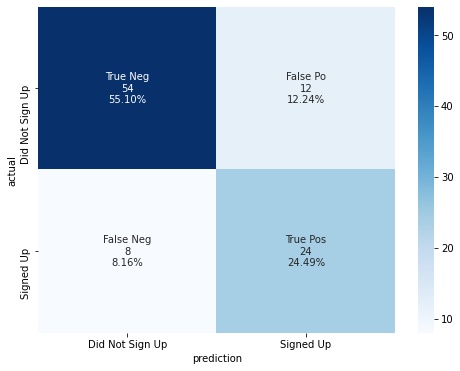

In [177]:
# Print confusion matrix with metrics
make_confusion_matrix(clf)

# XGBoost

In [178]:
df_train.head()

,Rewards_Signup,Age,Sex,Addtl_HH_size,LastPurchaseAmt,CustomerTier,New,Reactivated
0,1,29.0,0,0,10.5000,2,1,0
1,1,19.0,0,0,7.8792,3,0,0
2,0,25.0,1,0,7.0500,3,1,0
3,1,44.0,0,1,57.9792,1,0,1
4,1,32.0,1,0,7.9250,3,1,0


In [179]:
# Define target and features
#X = df_train.drop(columns='Rewards_Signup')
X = df_train[['Age', 'Sex', 'Addtl_HH_size', 'LastPurchaseAmt']]
y = df_train['Rewards_Signup']

# Split into train and test
X_test, X_val, y_test, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)

In [180]:
# Create model
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="binary:logistic",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go

gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='aucpr',
                    early_stopping_rounds=20,
                    verbose=False #gives output log as below
                   )

/Users/kaitlynzeichick/anaconda3/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Precision: 0.8507,   Recall: 0.7451
F1 Score:  0.7944250871080138
ROC AUC score :  0.9007145230973745
Accuracy score:  0.8483290488431876
Training accuracy: 0.8483290488431876
Test accuracy: 0.8483290488431876


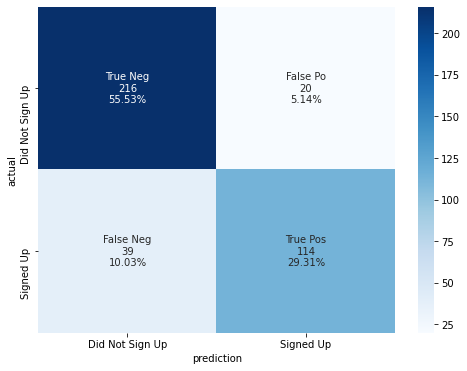

In [181]:
make_confusion_matrix(gbm)

# Final Test - XGBoost

In [192]:
X_test = df_test[['Age', 'Sex', 'Addtl_HH_size', 'LastPurchaseAmt']]
y_test = df_test['Rewards_Signup']

y_predict = (gbm.predict_proba(X_test)[:, 1] >= .5)

print("F1 Score: ", f1_score(y_test, y_predict))
print("ROC AUC score : ", roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))
print("*** Accuracy score: ", accuracy_score(y_test, y_predict))
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                        recall_score(y_test, y_predict)))

F1 Score:  0.7126436781609196
ROC AUC score :  0.8332792207792208
*** Accuracy score:  0.7807017543859649
Precision: 0.7209,   Recall: 0.7045
